Add the package to the path.

In [1]:
import sys
sys.path.append("C:/Users/A.C.EA/Documents/GitHub/QICKIT/")

Import `qickit` modules. For this demo, we will import the circuit instances.

In [2]:
from qickit.circuit import QiskitCircuit, PennylaneCircuit, CirqCircuit, TKETCircuit

We will also import some basic modules for angle calculations.

In [3]:
import numpy as np

### Circuits Demo : Creating and manipulating quantum circuits

This notebook is dedicated to the demonstration of how `qickit` can be used to create gate-based quantum circuits. In this notebook, we go over all of the currently available frameworks, and how our `Circuit` wrapper provides a consistent interface for accessing all of these frameworks.

To create circuits using our circuit wrapper instances such as `QiskitCircuit` and `CirqCircuit`, you simply define an instance, and then use the same syntax as outlined in the documentation to create a circuit. With our wrappers, you can create circuits in any package using a single syntax, and actively convert to and back from different frameworks in our supported list, allowing you to get the best out of all the packages and use any backend you desire.

C:\Users\A.C.EA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


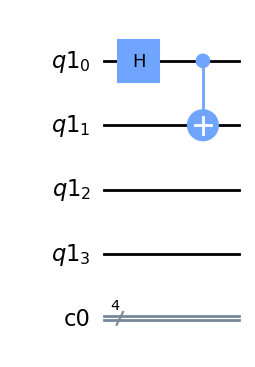

In [4]:
# Create a circuit
test_qc = QiskitCircuit(4, 4)

# Apply a Hadamard gate to qubit 0
test_qc.H(0)
# Apply a CX gate to qubit 1 controlled by 0
test_qc.CX(0, 1)

# Draw the circuit
test_qc.draw()

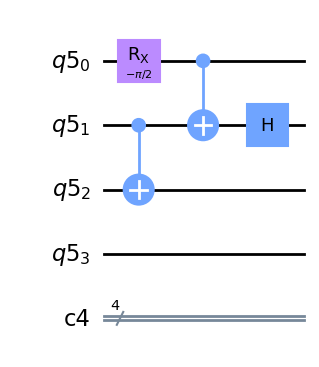

In [5]:
# Defining two circuits
test_qc1 = QiskitCircuit(4, 4)
test_qc2 = QiskitCircuit(4, 4)

# QC 1 provides a CX on qubits 1 and 2
test_qc1.CX(1, 2)

# QC 2 provides a Hadamard on qubit 1, and a CX on qubits 0 and 1
test_qc2.H(1)
test_qc2.CX(0, 1)
test_qc2.RX(np.pi/2, 0)

# We apply a horizontal_reverse, effectively switching the places for QC 2
test_qc2.horizontal_reverse(adjoint=True)

# We add the two circuits together
test_qc1.add(test_qc2, range(4))

test_qc1.draw()

### How to convert between the frameworks?

When converting to a different framework, you simply call the built-in method `.convert(other_framework)` allowing you to convert back and forth.

In [6]:
# Define a new circuit for the converted version
new_qc = test_qc1.convert(CirqCircuit)

new_qc.draw()

0: ───Rx(-0.5π)───@───────
                  │
1: ───@───────────X───H───
      │
2: ───X───────────────────


With existing intermediate frameworks like QASM 2.0, we also provide support for converting arbitrary frameworks to QASM 2.0 strings.

In [7]:
qasm_str = test_qc1.to_qasm()

qasm_str

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q5[4];\ncreg c4[4];\ncx q5[1],q5[2];\nrx(-pi/2) q5[0];\ncx q5[0],q5[1];\nh q5[1];\n'

#### How to run circuits?

When running the circuits, you can choose between the state vector or shots based measurement methods.

In [8]:
new_qc.get_statevector()

array([ 0.5,  0.5,  0.5, -0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ])

In [9]:
new_qc.get_counts(1024)

{'0000': 256.0,
 '0001': 256.0,
 '0010': 256.0,
 '0011': 256.0,
 '0100': 0.0,
 '0101': 0.0,
 '0110': 0.0,
 '0111': 0.0,
 '1000': 0.0,
 '1001': 0.0,
 '1010': 0.0,
 '1011': 0.0,
 '1100': 0.0,
 '1101': 0.0,
 '1110': 0.0,
 '1111': 0.0}

#### How to optimize the circuits?

`qickit` provides two categories of optimization, which depending on the purpose of the optimization may be chosen. The first category consists of IBM Qiskit's transpilation engine, which provides a lossless decomposition into U3 and CX gates, and allows for mild optimization in the process. This is useful for circuit to hardware mappings, which require paying attention to the native gates supported by the hardware.

The second category consists of standalone optimization algorithms, which provide low-level optimization, i.e., reordering CX gates such that the total number of CX gates is minimized without any loss of fidelity. These algorithms provide further support on top of IBM Qiskit's transpilation engine, and function to provide the best performance for the user's algorithms.

In [10]:
qc = CirqCircuit(4, 4)

qc.MCX([0, 1], [2, 3])

qc.transpile()

qc.draw()

0: ─────────────────@─────────────────@───@────U3───@────────────@─────────────────@───@────U3───@───
                    │                 │   │         │            │                 │   │         │
1: ────────@────────┼────────@───U3───┼───X────U3───X───@────────┼────────@───U3───┼───X────U3───X───
           │        │        │        │                 │        │        │        │
2: ───U3───X───U3───X───U3───X───U3───X───U3────────────┼────────┼────────┼────────┼─────────────────
                                                        │        │        │        │
3: ───U3────────────────────────────────────────────────X───U3───X───U3───X───U3───X───U3────────────


Another application of IBM Qiskit's transpilation engine is for calculating the effective depth - the longest sequence of U3 and CX gates - of the circuit, which through `qickit`'s conversion framework, provides a consistent calculation of the depth of the circuit for all of the supported frameworks. This is particularly useful for applications where the algorithm benefits from depth estimation, and if not done properly, different frameworks will provide drastically different results given the definition of depth, i.e., number of operations regardless of decomposition (where a MCX gate for instance would be considered as two gates, instead of twenty one).

In [11]:
qc = TKETCircuit(4, 4)

qc.MCX([0, 1], [2, 3])

print(qc.get_depth())

21


`qickit` provides many built-in features which make development as seamless as possible. With the wrapper approach, you reach a hardware agnostic implementation. However, since the wrapper supports almost all currently existing frameworks, you can access any backend through any framework without having to change syntax or your application.

`qickit` as of 2024 is still in the early stages of development, therefore there will be many more features such as further built-in optimizations, transpliations, and more backends available as it evolves.

<p>© 2024 Qualition Computing, all rights reserved.</p>